### About:
We present the single-cell graph autoencoder (scGAE), a dimensionality reduction method that preserves topological structure in scRNA-seq data. scGAE builds a cell graph and uses a multitask-oriented graph autoencoder to preserve topological structure information and feature information in scRNA-seq data simultaneously. We further extended scGAE for scRNA-seq data visualization, clustering, and trajectory inference. Analyses of simulated data showed that scGAE accurately reconstructs developmental trajectory and separates discrete cell clusters under different scenarios, outperforming recently developed deep learning methods. Furthermore, implementation of scGAE on empirical data showed scGAE provided novel insights into cell developmental lineages and preserved inter-cluster distances.

### Installation:
Download the model files (preprocessing.py, scgae.py, layers.py, losses.py, and utils.py) in this repository and import functions in them.

### Quick start:
1.Prepare datasets  
scGAE takes preprocessed data as input. Single cell data preprocessing can be done with Seurat R package and scanpy python package.   
2.Model building  
Compute the adjacency matrix using get_adj function and build the SCGAE model.  
3.Model training  
Train the model with model.train() function.  
4.Clustering training (optional)  
After getting the clustering centers using get_centers_louvain function, perform the clustering training using model.clustering_train() function.  
5.Generate embedding  
Get the latent embedding of the data by model.embedding().  

In [1]:
#Import packages
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#scGAE modules
from scgae import SCGAE
from preprocessing import *
from utils import *
from losses import *
from clustering import *

### Load the data 
scGAE takes preprocessed data as input. This demodata is already preprocessed using scTransform in the Seurat R package.

In [2]:
# Load data
# count = np.array(pd.read_csv("data5_sct.csv", index_col=0, sep="\t"))
# idents = np.array(pd.read_csv("group5.csv", index_col=0, sep="\t")).reshape(-1,)
count = np.load('count.npy')
idents = np.load('idents.npy')

### Compute adjacency matrix
Parameters:  
"k": the number of nearest neighbors when calculating adjacency matrix, it is recommend to set around tenth of your number of cells. Default is 160.

In [3]:
# Compute adjacency matrix and normalized adjacency matrix
adj, adj_n = get_adj(count, k = 160) 

### Build the scGAE model  
Parameters:  
"count": the normalized count matrix.  
"adj" and "adj_n": the adjacency matrix and normalized adjacency matrix get in the last step.  
"latent_dim": latent dimension of the dimensionnality reduction output, optional, default 15.  
"hidden_dim": hidden dimension of the encoder graph neural network, optional, default 120.  
"decA": adjancency matrix decoder. Can be "DBL" for dense bilinear decoder and "BL" for bilinear decoder. Default is "DBL".  
"layer_enc": graph neural network layer in the encoder: "GAT" for graph attention layer,
             "TAG" for topology adaptive graph convolutional layer.
             Default is "GAT", "TAG" performs better in some clustering data but is slower.

In [4]:
model = SCGAE(count, adj, adj_n, hidden_dim = 120, latent_dim = 15, decA = "DBL", layer_enc = "GAT")

### Model training

Training without clustering process:  
Parameters:  
"epochs": the numper of training epochs, default: 80  
"lr": learning rate, default: 2e-3  
"W_a": weight of adjacency matrix reconstruction loss, default 0.4  
"W_x": weight of count matrix reconstruction loss, default is 1  

In [6]:
model.train(epochs = 80, W_a = 0.4, W_x = 1)

Pre_train Finish!


In [6]:
#Genertate latent embedding by tSNE
Y = model.embedding(count, adj_n)
Y2 = dotsne(Y)

<AxesSubplot:>

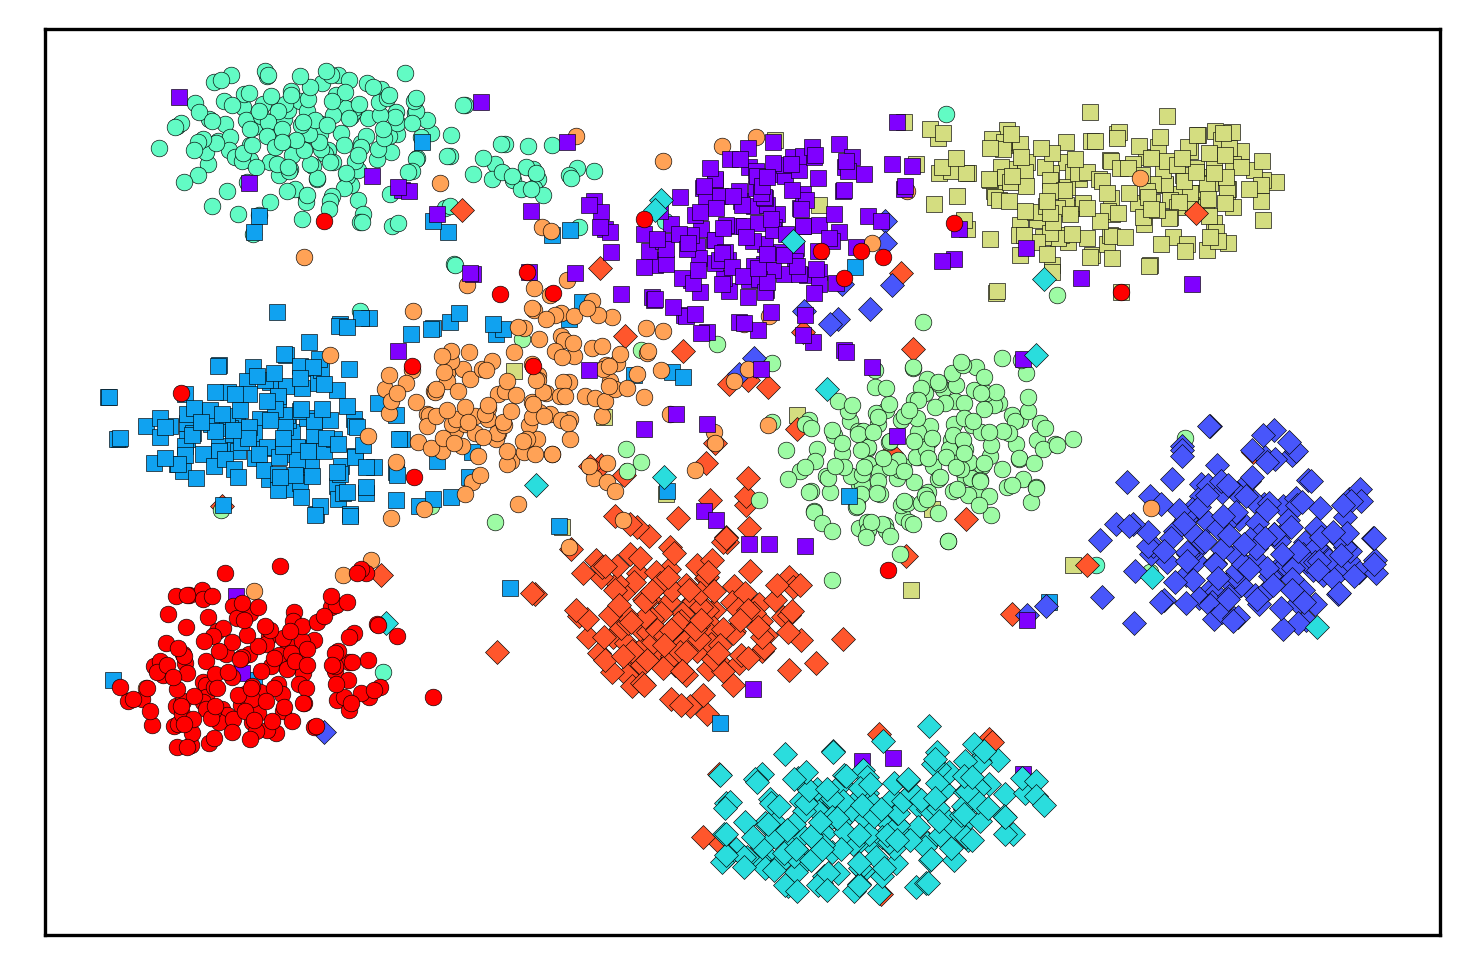

In [7]:
myscatter(Y2, idents)

### Get initialized clustering center
We provide two options for initializing centers for clustering training: the Louvain clustering and spectral clustering.   
In the case you know the number of clusters, spectral clustering is recomended.  
In the case you don't know the number of clusters, you need the Louvain clustering.  

In [8]:
# Louvain clustering
#centers, labels = get_centers_louvain(Y, adj)

# Spectral clustering 
centers, labels = get_centers_spectral(Y, adj)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


### Alternative clustering training  
Parameters:  
"centers": the initialized clustering centers get in the last step.  
"epochs": training epochs, default is 40.  
"lr": learning rate, default is 5e-4.  
"W_a": weight of adjacency matrix reconstruction loss, default 0.4.  
"W_x": weight of count matrix reconstruction loss, default is 1.  
"W_c": weight of clustering loss, default is 0.8.  
"n_update": frequency of update cluster centers, default is 8.

In [9]:
model.clustering_train(centers=centers, W_a = 0.4, W_x = 1, W_c = 1.5, epochs = 40)

Epoch 10  X_rec_loss:  1.0190467  A_rec_loss:  0.079999946  cluster_loss:  0.19394702
Epoch 20  X_rec_loss:  1.0279603  A_rec_loss:  0.079999946  cluster_loss:  0.2034982
Epoch 30  X_rec_loss:  1.0399683  A_rec_loss:  0.079999946  cluster_loss:  0.20372726
Epoch 40  X_rec_loss:  1.0485584  A_rec_loss:  0.079999946  cluster_loss:  0.34065562


<AxesSubplot:>

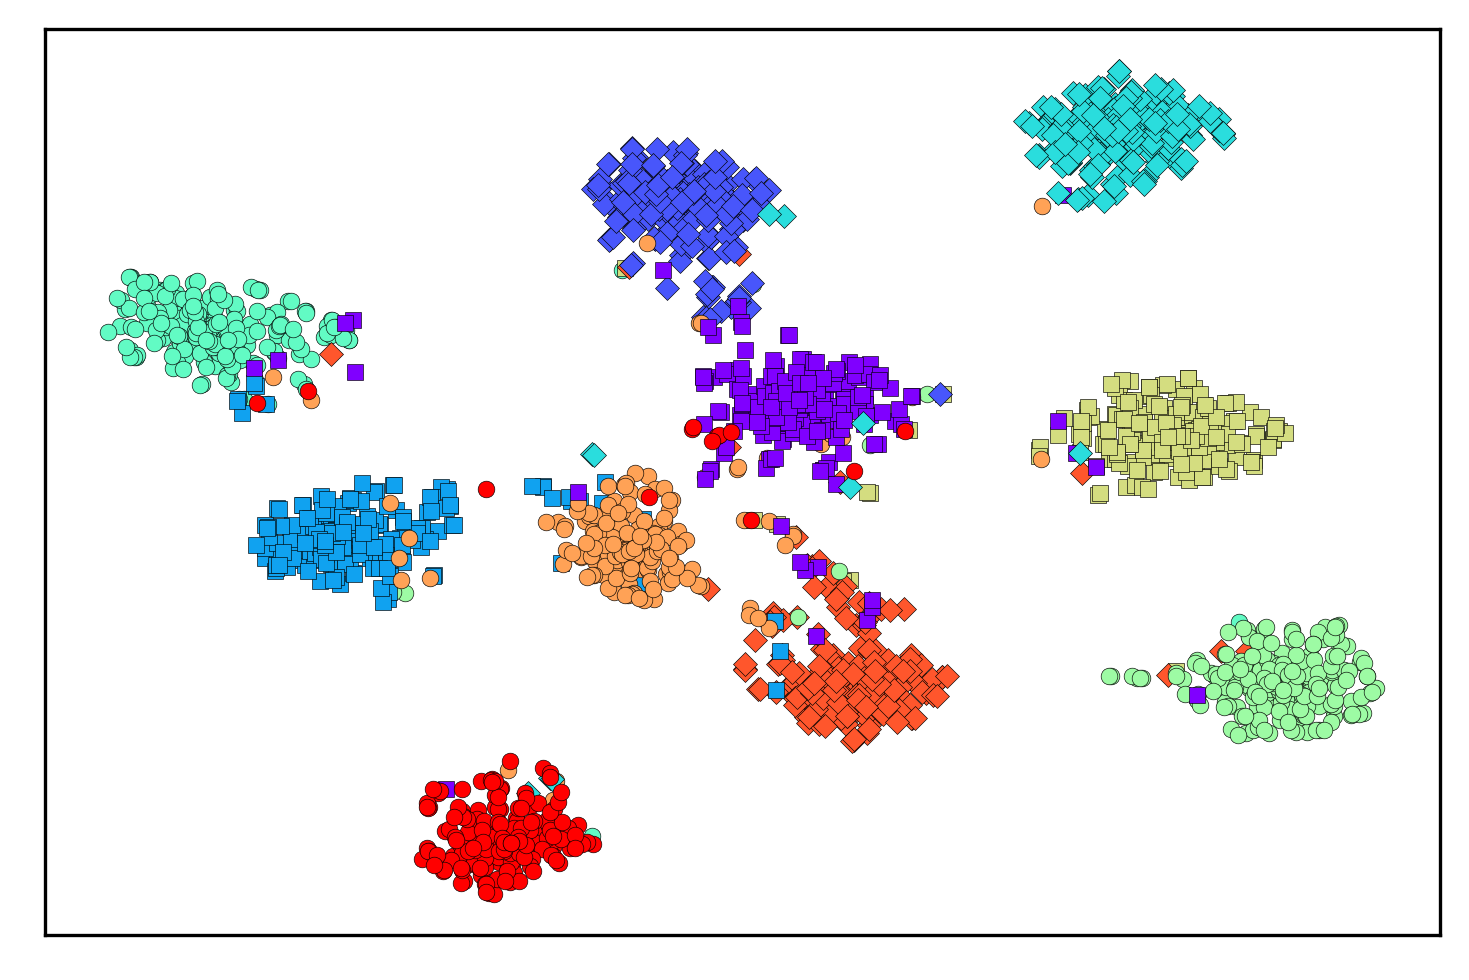

In [10]:
# Genertate latent embedding and visualization after clustering-training
Yc = model.embedding(count, adj_n)
Y2c = dotsne(Yc, dim=2)
myscatter(Y2c, idents)

### Evaluate clustering performance  
Compare the normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score between ground truth clusters and infered clusters.  
Parameters:  
"n_cluster": the number of clusters  
"k": the number of nearest neighbors when getting adjacency matrix.  
"f": the clustering method, can be 'louvain', 'spectral', and 'Kmenas'.

In [11]:
labels = clustering(Y2c, n_cluster=10, f='louvain')
measure(idents, labels)

[0.75, 0.58, 0.88, 0.66]

### Evaluate linage inference 
We Evaluate linage inference using DPT package. We compare the ground truth pseudotime with the dpt inferenced pseudotime by kendall correlation.

In [12]:
#tau, pesudotime = dpt(times, Y2)
#tau